Download data

In [2]:
!pip install fsspec
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=da768270b06785d5deb69be2f70eec7e3dcfcb8174d8f225ccb57e6424463443
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [3]:
import fsspec
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

destination = Path("data")
destination.mkdir(exist_ok=True, parents=True)
fs = fsspec.filesystem("github", org="lorenzovecchietti", repo="FinanceAI")
fs.get(fs.ls("data/"), destination.as_posix())

In [4]:
import os

def concatenate_text_files(folder_path, output_file):
    # List to hold the names of text files
    text_files = sorted([f for f in os.listdir(folder_path) if f.startswith("SPY")])

    with open(output_file, 'w', encoding='utf-8') as outfile:
        for filename in text_files:
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as infile:
                outfile.write(infile.read())  # Add newline for separation

# Example usage
folder_path = 'data'  # Replace with your folder path
output_file = 'data/1_min_SPY_2008-2021.csv'  # Output file name
concatenate_text_files(folder_path, output_file)

## Data Preparation

In [5]:
import pandas as pd
df=pd.read_csv(output_file, header=1, dtype={"Open":np.float32, "High":np.float32, "Low":np.float32, "Close":np.float32, "Volume":np.uint8,"Bars":np.uint8, "Average":np.float32}, names=["","DateTime Stamp", "Open", "High", "Low", "Close", "Volume","Bars", "Average"],usecols=[1,2,3,4,5,6,7,8], index_col=0, parse_dates=True, date_format='%Y%m%d  %H:%M:%S', sep=",")
print(df.head())

                          Open       High        Low      Close  Volume  Bars  \
DateTime Stamp                                                                  
2009-05-22 07:31:00  89.379997  89.529999  89.370003  89.500000     216   146   
2009-05-22 07:32:00  89.510002  89.540001  89.480003  89.489998      21   160   
2009-05-22 07:33:00  89.489998  89.489998  89.309998  89.339996     167   216   
2009-05-22 07:34:00  89.330002  89.459999  89.330002  89.389999       3    77   
2009-05-22 07:35:00  89.379997  89.410004  89.169998  89.180000      98    62   

                       Average  
DateTime Stamp                  
2009-05-22 07:31:00  89.468002  
2009-05-22 07:32:00  89.515999  
2009-05-22 07:33:00  89.386002  
2009-05-22 07:34:00  89.378998  
2009-05-22 07:35:00  89.273003  


# Clean Data

In [6]:
df.sort_index(inplace=True) # sort by date
df.drop_duplicates(keep='first', inplace=True) # Remove duplicate rows

## Check data

Check if there is any missing data

In [7]:
# Calculate the difference in minutes
diff_series = df.index.to_series().diff().dt.total_seconds() / 60

# Create a boolean mask for validity
validity_series = (diff_series == 1) | (df.index != df.index.to_series().shift(1))

# Convert to a Series with the same index
validity_series = pd.Series(validity_series.values, index=df.index)

# Print invalid entries
print(validity_series[~validity_series])

Series([], dtype: bool)


Print data description and plot

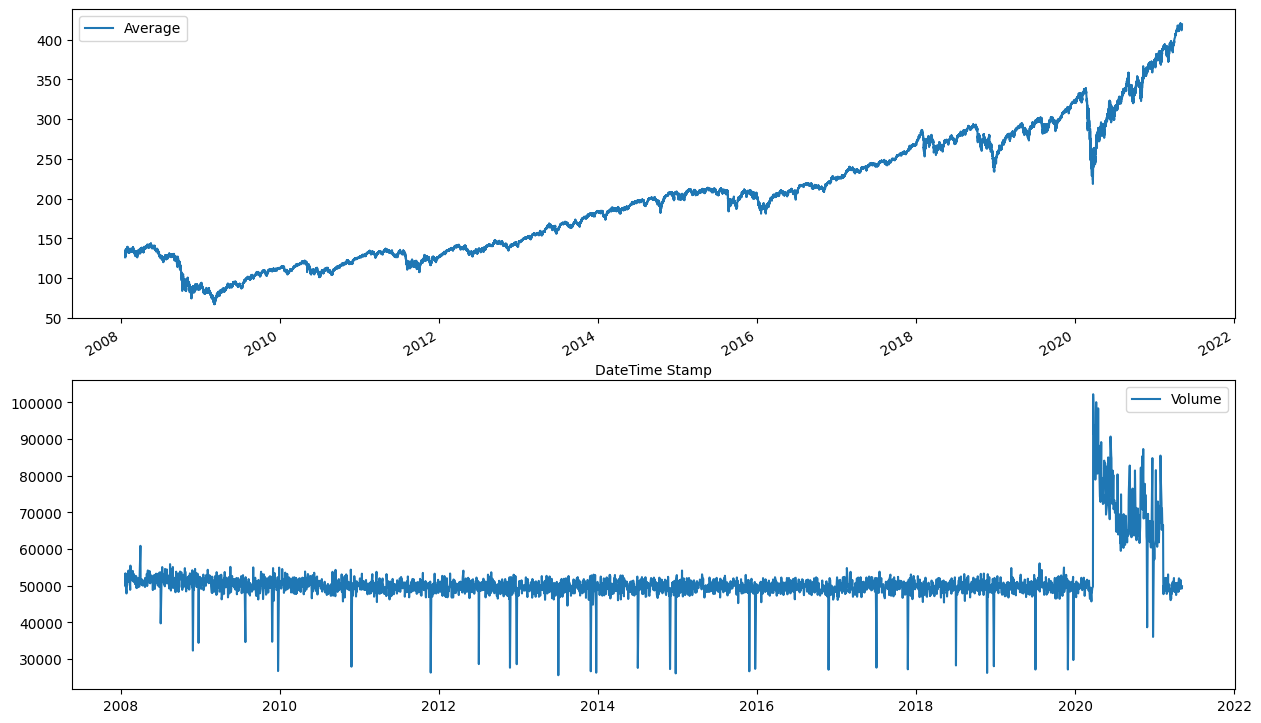

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
df.plot(y=['Average'], ax=axs[0])
df.groupby(by=df.index.date).sum().plot(y=['Volume'], ax=axs[1])
fig.show()

## Expanding data with trading indicators

In [9]:
import pandas_ta as ta

Resample data on the 5 minutes timeframe.

In [10]:
df=df.resample('5min').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', "Average": "mean", 'Volume': 'sum'})

Add TA to the dataframe.

In [11]:
df['EMA_20'] = ta.ema(df['Close'], length=20)
fast=12; slow=26; signal=9
macd = ta.macd(df['Close'], fast=fast, slow=slow, signal=signal)
df['MACD'] = macd[f"MACD_{fast}_{slow}_{signal}"]
df['MACD_Hist'] = macd[f"MACDh_{fast}_{slow}_{signal}"]
l=(20,10); std=(2.0,1.9)
for a,b in zip(l, std):
  df = pd.concat([df, ta.bbands(df['Close'], length=a, std=b)], axis=1)
df['RSI'] = ta.rsi(df['Close'], length=14)
df['VWAP'] = ta.vwap(df['High'], df['Low'], df['Close'], df['Volume'])
df['OBV'] = ta.obv(df['Close'], df['Volume'])
l=14
df["ADX"]=ta.adx(df['High'], df['Low'], df['Close'], length=l)[f"ADX_{l}"]
df['CMF'] = ta.cmf(df['High'], df['Low'], df['Close'], df['Volume'], length=20)
df['ROC'] = ta.roc(df['Close'], length=12)
df.dropna(subset="Open",inplace=True)

Plot of the different measures

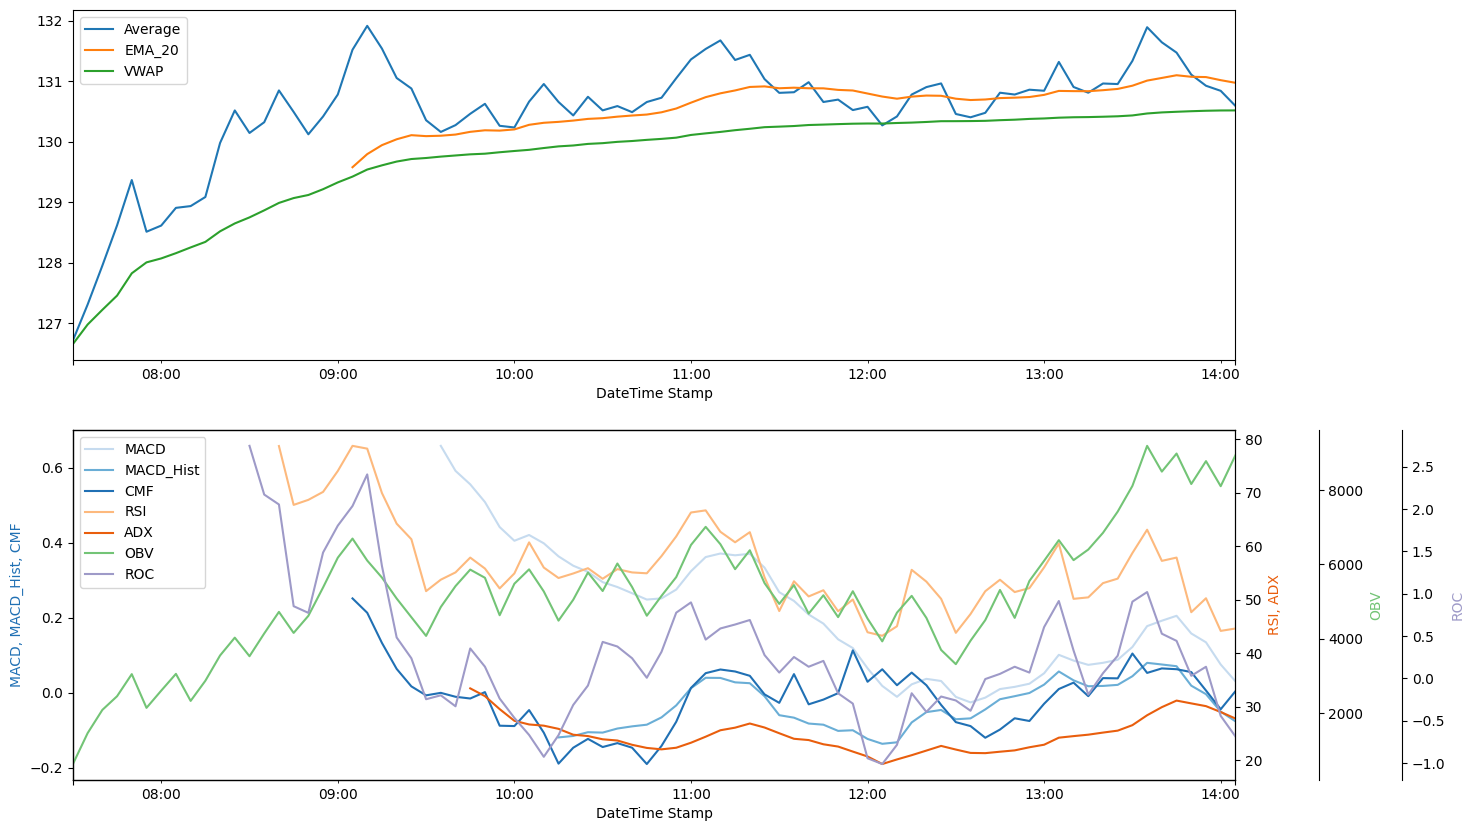

In [24]:
colors=['Blues', 'Oranges', 'Greens', 'Purples']

fig, axs = plt.subplots(2, 1,figsize=(15, 10))

df.head(80).plot(y=['Average', 'EMA_20', 'VWAP'], ax=axs[0])

lines=[]
labels=[]
for j, cols in enumerate([['MACD', 'MACD_Hist', 'CMF'], ['RSI', 'ADX'], ['OBV'], ["ROC"]]):
  if j>0:
    current_ax = axs[1].twinx()
    current_ax.spines['right'].set_position(('outward', 60*(j-1)))
  else:
    current_ax = axs[1]
  cmap = plt.get_cmap(colors[j])
  norm = plt.Normalize(-1, len(cols))

  for i in range(0, len(cols)):
    c=cmap(norm(i))
    df.head(80).plot(y=cols[i], ax=current_ax, color=c, use_index=True)

  current_ax.set_ylabel(', '.join(cols), color=c)
  li, la = current_ax.get_legend_handles_labels()
  lines+=li
  labels+=la
  current_ax.get_legend().remove()

axs[1].legend(lines, labels, loc='upper left')

fig.show()